In [1]:
# Hide warnings on Jupyter Notebook
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import os
import gc
import glob
import numpy as np

#this is what makes the plots transparent in notebooks
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot

from keras.models import load_model

from vis.visualization import visualize_saliency
from vis.visualization import visualize_cam
from vis.utils import utils
from keras import activations

Using TensorFlow backend.


In [2]:
# img_width = 32
# img_height = 32
model = load_model('model_0.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 4)         104       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 10)        1010      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 10)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               25100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total para

In [12]:
render_folder = os.path.join(os.getcwd(), "..","greebles_10") #reduced dataset of 10
set_mode = 'specific_all'
set_type = 'specific_angle'
source_folder = os.path.join(render_folder, "greebles_tf-" + set_mode, set_type)
test_set_name = "greebles10_test_-90_90_1.npy"
labels = {0: 'f-1', 1: 'f-2', 2: 'f-3', 3: 'f-4', 4: 'f-5', 5: 'm-1', 6: 'm-2', 7: 'm-3', 8: 'm-4', 9: 'm-5'}
test_set_path = os.path.join(source_folder, test_set_name)
all_test = np.load(test_set_path, allow_pickle=True).item()

(10, 32, 32, 1)


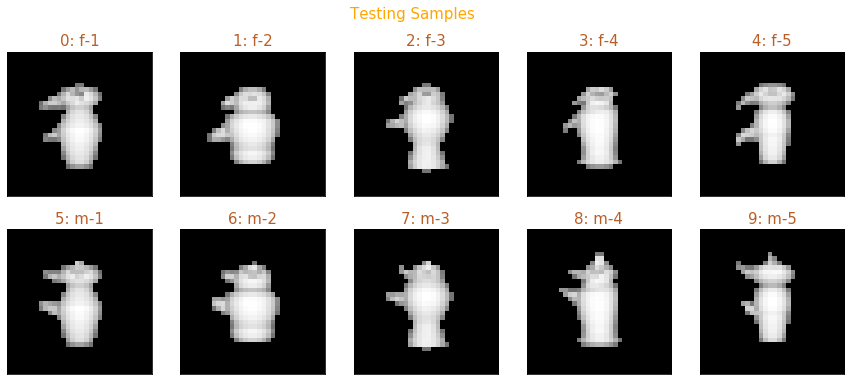

In [15]:
# Display one specific angle just as an example of what images are we using
angle_used = '-90'
(x_test, y_test) = np.copy(all_test[angle_used][0]), np.copy(all_test[angle_used][1])
# Make background the same color
x_test[x_test < 70] = 0
x_test *= (1.0/255)
print(x_test.shape)

fig, axes = plt.subplots(2, 5, figsize=(15,6))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_test[i][:,:,0], cmap='gray')
    true_label = np.argwhere(y_test[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=labels[int(true_label)], number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Testing Samples', fontsize=15, color='orange')

plt.show()

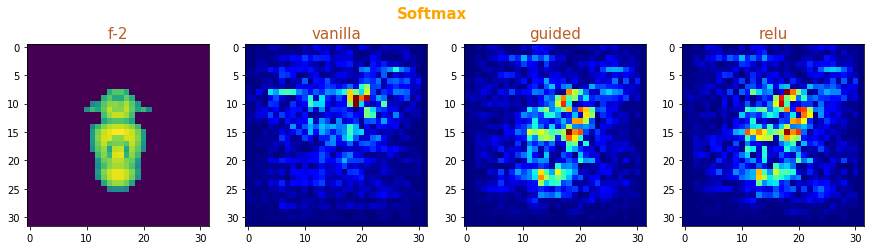

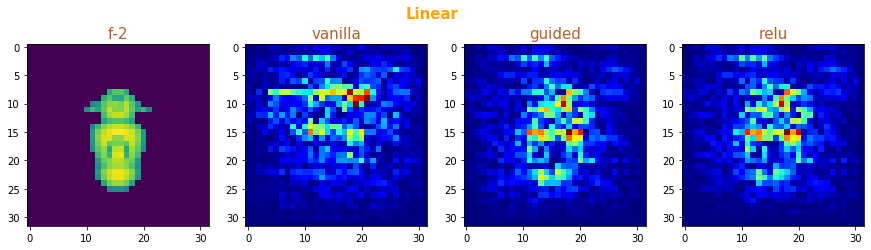

In [5]:
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'dense_2')

# Example saliency visualization
class_idx = 1
indices = np.where(y_test[:, class_idx] == 1.)[0]
idx = indices[0] # pick some random input from here.

# Remove eventually to speed up
model.layers[layer_idx].activation = activations.softmax
model = utils.apply_modifications(model)

fig, ax = plt.subplots(1, 4, figsize=(15,6))
ax[0].set_title(labels[class_idx], fontsize=15, color='#ba5e27')
ax[0].imshow(x_test[idx][..., 0])

for i, modifier in enumerate([None, 'guided', 'relu']):
    grads = visualize_saliency(model, layer_idx, filter_indices=class_idx,
                               seed_input=x_test[idx], backprop_modifier=modifier)
    if modifier == None:
        modifier = 'vanilla'
    ax[i+1].set_title(modifier, color='#ba5e27', fontsize=15)
    ax[i+1].imshow(grads, cmap='jet')
fig.suptitle('Softmax', fontsize=15, color='orange', fontweight ="bold", y=0.8)
#############################################
# Swap softmax with linear for better results
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

fig, ax = plt.subplots(1, 4, figsize=(15,6))
ax[0].set_title(labels[class_idx], fontsize=15, color='#ba5e27')
ax[0].imshow(x_test[idx][..., 0])

for i, modifier in enumerate([None, 'guided', 'relu']):
    grads = visualize_saliency(model, layer_idx, filter_indices=class_idx,
                               seed_input=x_test[idx], backprop_modifier=modifier)
    if modifier == None:
        modifier = 'vanilla'
    ax[i+1].set_title(modifier, color='#ba5e27', fontsize=15)
    ax[i+1].imshow(grads, cmap='jet')
fig.suptitle('Linear', fontsize=15, color='orange', fontweight ="bold", y=0.8)

plt.show()

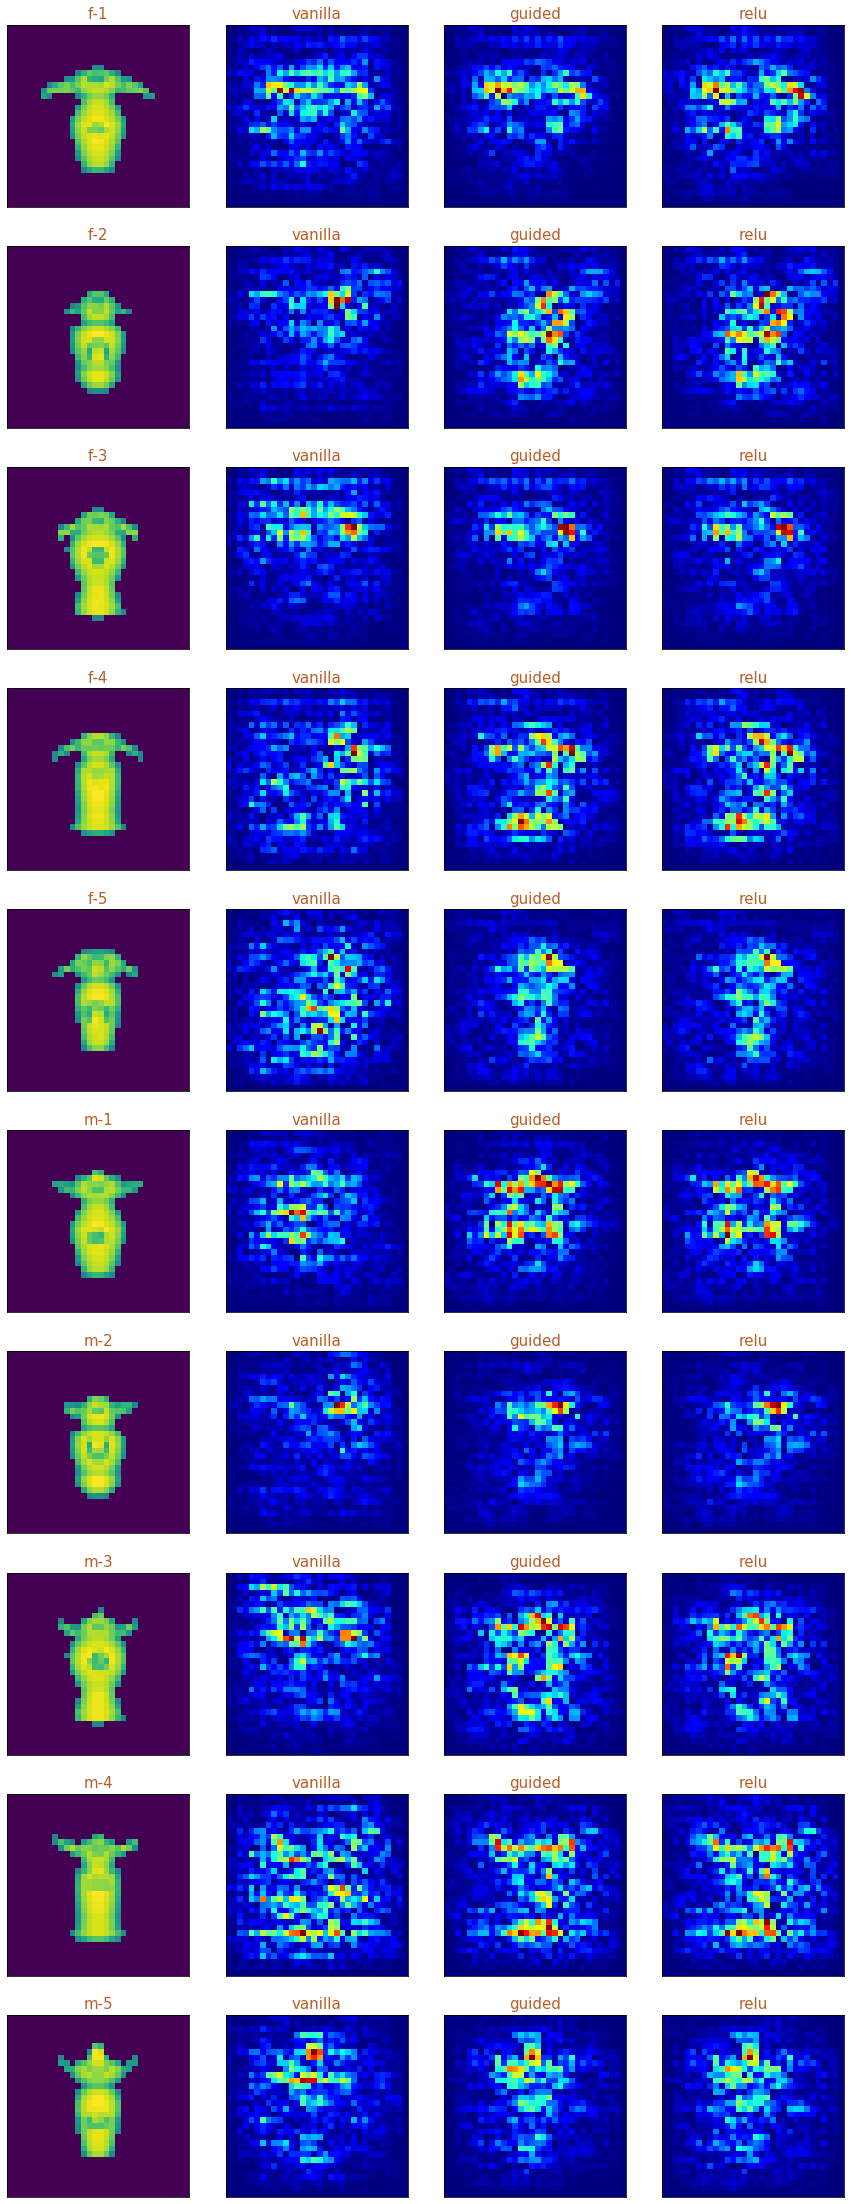

In [6]:
# Remove eventually to speed up
model.layers[layer_idx].activation = activations.softmax
model = utils.apply_modifications(model)
fig, ax = plt.subplots(10, 4, figsize=(15,4*10))
ax = ax.ravel()
for class_idx in range(10):    
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]

    offset = class_idx*4
    ax[offset].set_title(labels[class_idx], fontsize=15, color='#ba5e27')
    ax[offset].imshow(x_test[idx][..., 0])
    ax[offset].set_yticklabels([])
    ax[offset].set_xticklabels([])
    ax[offset].tick_params(axis=u'both', which=u'both', length=0)
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
                                   seed_input=x_test[idx], backprop_modifier=modifier)
        if modifier is None:
            modifier = 'vanilla'
        ax[offset+i+1].set_title(modifier, color='#ba5e27', fontsize=15)
        ax[offset+i+1].imshow(grads, cmap='jet')
        ax[offset+i+1].set_yticklabels([])
        ax[offset+i+1].set_xticklabels([])
        ax[offset+i+1].tick_params(axis=u'both', which=u'both', length=0)
    
# Clear memory
plt.show()
fig.clf()
plt.close(fig)
gc.collect()

model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

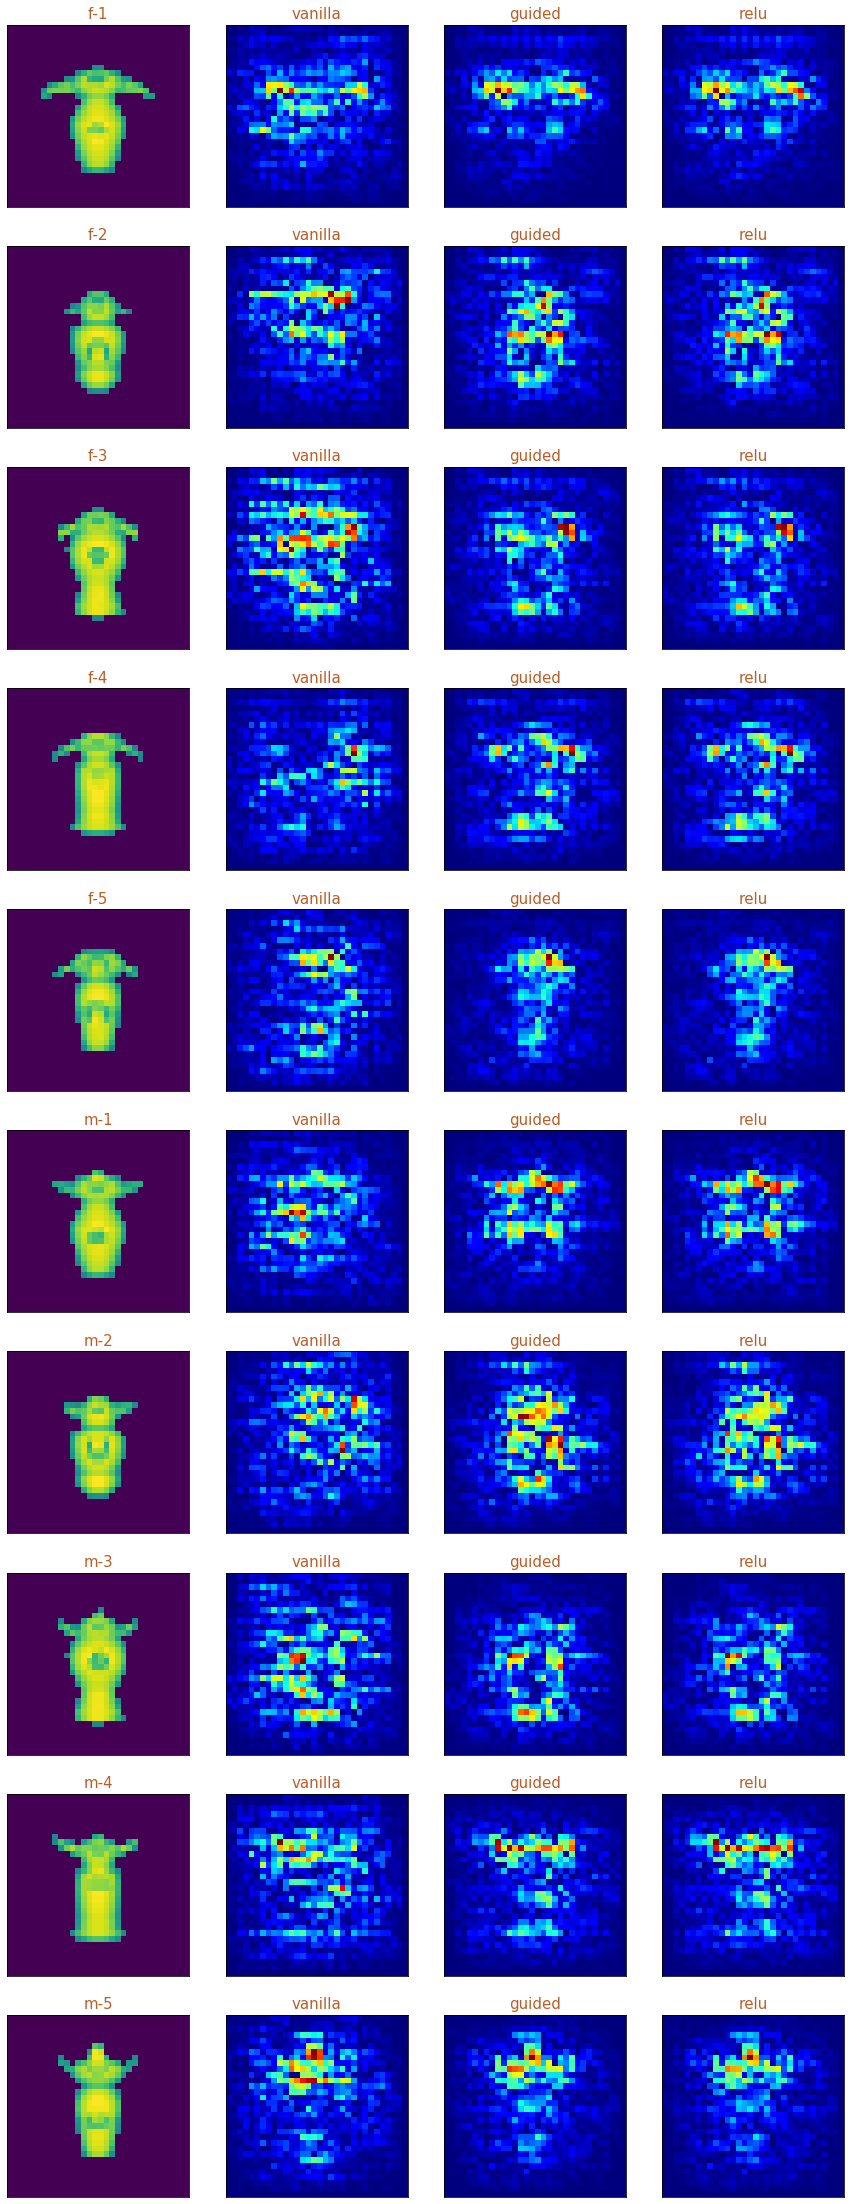

12515

In [7]:
# This corresponds to the Dense linear layer.
fig, ax = plt.subplots(10, 4, figsize=(15,4*10))
ax = ax.ravel()
for class_idx in range(10):    
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]

    offset = class_idx*4
    ax[offset].set_title(labels[class_idx], fontsize=15, color='#ba5e27')
    ax[offset].imshow(x_test[idx][..., 0])
    ax[offset].set_yticklabels([])
    ax[offset].set_xticklabels([])
    ax[offset].tick_params(axis=u'both', which=u'both', length=0)
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
                                   seed_input=x_test[idx], backprop_modifier=modifier)
        if modifier is None:
            modifier = 'vanilla'
        ax[offset+i+1].set_title(modifier, color='#ba5e27', fontsize=15)
        ax[offset+i+1].imshow(grads, cmap='jet')
        ax[offset+i+1].set_yticklabels([])
        ax[offset+i+1].set_xticklabels([])
        ax[offset+i+1].tick_params(axis=u'both', which=u'both', length=0)
    
# Clear memory
plt.show()
fig.clf()
plt.close(fig)
gc.collect()

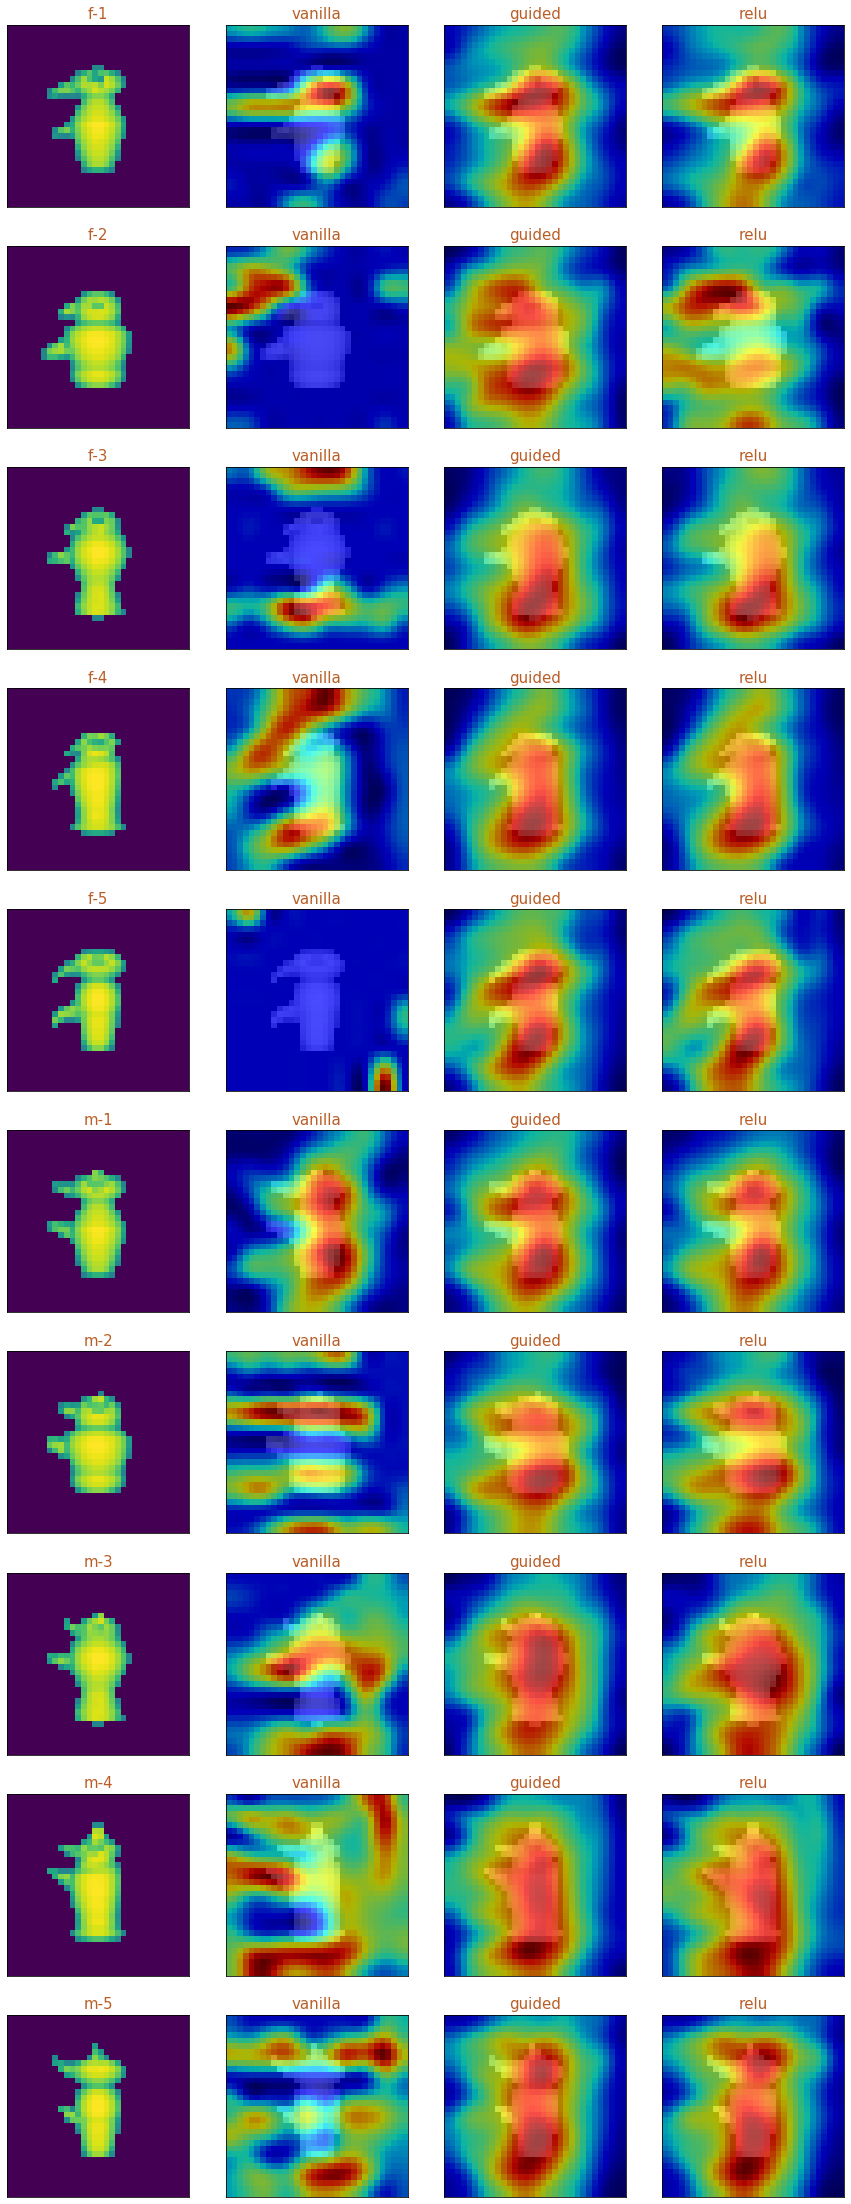

94567

In [16]:
# grad-CAM
layer_idx = utils.find_layer_idx(model, 'dense_2')
# layer_idx = utils.find_layer_idx(model, 'conv2d_2')

penultimate_layer = utils.find_layer_idx(model, 'conv2d_2')

fig, ax = plt.subplots(10, 4, figsize=(15,4*10))
ax = ax.ravel()
for class_idx in range(10):    
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]

    offset = class_idx*4
    ax[offset].set_title(labels[class_idx], fontsize=15, color='#ba5e27')
    ax[offset].imshow(x_test[idx][..., 0])
    ax[offset].set_yticklabels([])
    ax[offset].set_xticklabels([])
    ax[offset].tick_params(axis=u'both', which=u'both', length=0)
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
                                     seed_input=x_test[idx], backprop_modifier=modifier,
                                     penultimate_layer_idx=penultimate_layer)
        if modifier is None:
            modifier = 'vanilla'
        ax[offset+i+1].set_title(modifier, color='#ba5e27', fontsize=15)
        ax[offset+i+1].imshow(grads, cmap='jet')
        
        ax[offset+i+1].imshow(x_test[idx][..., 0], cmap='gray', alpha=0.29)
        
        ax[offset+i+1].set_yticklabels([])
        ax[offset+i+1].set_xticklabels([])
        ax[offset+i+1].tick_params(axis=u'both', which=u'both', length=0)
    
# Clear memory
plt.show()
fig.clf()
plt.close(fig)
gc.collect()

In [11]:
# We have to do everything inside this loop, create video, etc
os.makedirs('saliency', exist_ok=True)
for c, current_angle in enumerate(all_test.keys()):
    if os.path.exists("saliency/{}_sal_{}.png".format(str(c).zfill(3), current_angle)):
        print("Skipped {}".format(current_angle))
        continue
    
    if (int(current_angle)%10) != 0: pass
    else:
        print(current_angle, end=", ")        
        (x_test, y_test) = np.copy(all_test[current_angle][0]), np.copy(all_test[current_angle][1])
        
        # Make background the same color
        x_test[x_test < 70] = 0
        
        x_test *= (1.0/255)
        
        fig, ax = plt.subplots(10, 4, figsize=(15,4*10))
        ax = ax.ravel()
        for class_idx in range(10):    
            indices = np.where(y_test[:, class_idx] == 1.)[0]
            idx = indices[0]

            offset = class_idx*4
            ax[offset].set_title(labels[class_idx], fontsize=15, color='#ba5e27')
            ax[offset].imshow(x_test[idx][..., 0])
            ax[offset].set_yticklabels([])
            ax[offset].set_xticklabels([])
            ax[offset].tick_params(axis=u'both', which=u'both', length=0)

            for i, modifier in enumerate([None, 'guided', 'relu']):
                grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
                                           seed_input=x_test[idx], backprop_modifier=modifier)
                if modifier is None:
                    modifier = 'vanilla'
                ax[offset+i+1].set_title(modifier, color='#ba5e27', fontsize=15)
                ax[offset+i+1].imshow(grads, cmap='jet')
                ax[offset+i+1].set_yticklabels([])
                ax[offset+i+1].set_xticklabels([])
                ax[offset+i+1].tick_params(axis=u'both', which=u'both', length=0)
        
        plt.savefig("saliency/{}_sal_{}.png".format(str(c).zfill(3), current_angle), dpi=150, bbox_inches = "tight")
        
        # Clear memory
#         plt.show()
        fig.clf()
        fig.clear()
        plt.close(fig)
        gc.collect()

print("Done\n")
print(x_test.shape)
print(y_test.shape)

-90, -80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, Done

(10, 32, 32, 1)
(10, 10)


In [10]:
import cv2

fps = 3
fp_in = "saliency/*_sal_*.png"
fp_in_1 = "saliency/000_sal_-90.png"
fp_out = "saliency/animated_sal.avi".format(fps)

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
imgs = [cv2.imread(f) for f in glob.glob(fp_in_1)]
height, width, layers = imgs[0].shape
print(height, width)
size = (width,height)
out = cv2.VideoWriter(fp_out,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

imgs = glob.glob(fp_in)
imgs.sort(key=os.path.getmtime)
for i in imgs:
    # writing to a image array
    out.write(cv2.imread(i))
out.release()

print("Done!")

9182 3547
Done!
